# TODO
- Implement ConvNet model
- Implement loading of CIFAR10 dataset
- Write training scheme for the buffer
- Write training scheme for the distillation
- When halfway through training epochs, cut lr by half like in MTT paper
- The giant bottleneck in this model is the time wasted on `__getitem__`: applying transforms and endless calls to this function takes up 72% (!!!) of all time spent during training, which is obscene (in comparison, it takes 20ms for a single batch forward pass thanks to CUDA, or 5000/256 * 20 = 390ms for one epoch, compared to about 6s doing transforms). For normalization, this is something that can easily be done on the dataset during initialization, and have to check, but I think MTT doesn't do random transforms doing training of the expert trajectories. It may be worth just doing something like in the MTT repo, lines 38-60 in buffer.py, they seem to have had the same problem.


# Dataset Distillation by Matching Training Trajectories

Implementation of the MTT method, based on the [code by the paper's authors](https://github.com/GeorgeCazenavette/mtt-distillation/tree/main). This implementation uses Jupyter notebooks to visualize the model, and is also not dependent on any online services like in the original implementation.

- Model used: ConvNet (as implemented by the MTT paper)
- Dataset used: CIFAR10, CIFAR100

To get started, you can run the notebook as is, or modify settings the User Settings section.


## Setup

The following cells will import important packages, configure devices, load TensorBoard etc

In [1]:
import sys
import os
from typing import Any, Callable, Tuple, Dict, List, Optional, Union
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor
import matplotlib.pyplot as plt

from src.train_experts import print_line, init_logger, set_device

In [2]:
# Set up device
device = set_device()
print(f"device being used: {device}")

device being used: cuda


In [3]:
# Set up Matplotlib so that it properly visualizes inside Jupyter notebook using VSCode

plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

In [4]:
# Some small fixes to prevent Jupyter from bugging out

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# To prevent the kernel from dying.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


In [5]:
# Set up TensorBoard

""" Notes on superbuggy VSCode tensorboard

The general conclusion is that Tensorboard in VSCode breaks regularly for whatever reasons, and nobody
cares to fix it. So just use Tensboard from the browser. Code below will run tensorboard on port 6006

For some reason tensorboard isn't quitting properly, and keeps the port occupied even
if the process itself is killed. Maybe it will be patched someday...

1. Check Code Python Interpreter is correct

2. Check if port occupied:
lsof -i:6006

Kill using the PID from above command (not 6006, the PID!):
kill PID

See https://stackoverflow.com/questions/54395201/tensorboard-could-not-bind-to-port-6006-it-was-already-in-use
Also, see this on how to kill tensorboard process (but not the problem here): https://stackoverflow.com/questions/36896164/tensorflow-how-to-close-tensorboard-server

3. Alternative if you want to see tensorboard in a webbrowser (6006, 8888 etc):
tensorboard --logdir=data/ --host localhost --port 6006
http//localhost:6006

Another possible bug is that installing tensorboard with conda is not visible in Jupyter Notebooks using VSCode. You will have to reinstall it using pip instead

"""

%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir=logs/ --port 6006

# User Settings

Here you can define the most important aspects of the notebook.

In [6]:
from torchvision.datasets import CIFAR10, CIFAR100

# User settings:
settings: dict[str, Any] = {
    "dataset": "CIFAR10",  # [CIFAR10, CIFAR100]
    "model": "ConvNet",  # [ConvNet, ResNet]
    "ZCA": False,  # [True, False]
}


# Hyperparameters
hparams: dict[str, Any] = {
    # General hyperparameters
    "device": device,
    "num_workers": 16,
    "epochs": 50,
    "batch_size": 256,
    "max_patience": 3,
    "learning_rate": 0.01,
    "weight_decay": 0.0,
    "momentum": 0.0,
    # Model specific hyperparameters
    "img_shape": (3, 32, 32),  # C x H x W
    "out_channels": 10,  # Number of output channels (e.g. 100 for CIFAR100)
    "net_depth": 3,  # Number of Conv layers (excluding helper layers and additional linear layer)
    "net_width": 128,  # Number of kernels in each Conv layer
    "kernel_size": 3,  # Dimensions of the kernels (H * W)
    "padding": 1,  # Conv layer padding
    "activation": nn.ReLU(inplace=True),  # Activation function
    "norm": nn.GroupNorm(
        num_groups=128, num_channels=128, affine=True
    ),  # Normalization technique
    "pooling": nn.AvgPool2d(kernel_size=2, stride=2),  # Pooling method
    "optimizer": "SGD",  # Optimizer to use for training
}

# Download and prepare dataset

The models used in this notebook are already provided by PyTorch itself, so we can simply download and modify them. However, the PyTorch class not accept slice indexes, so we will have to write our own little version on top of it which fixes the __getitem__ method. That way, we can do something like train_dataset[0:3] and not just train_dataset[1],

In [8]:


train_dataset = None
test_dataset = None


assert train_dataset != None and test_dataset != None

Loading training dataset (CIFAR10)
Files already downloaded and verified
Loading testing dataset (CIFAR10)
Files already downloaded and verified


In [9]:
# Show some basic information about the dataset



Training set size: 50000
Test set size: 10000
Image dimensions: torch.Size([3, 32, 32])
Target type: <class 'int'>


In [10]:
# Function to visualize data

# TODO: use torch.tensor.view instead of transpose when possible




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


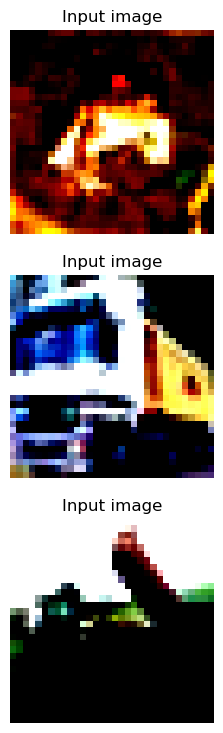

In [11]:
# Show some of the dataset. Note that normalization means the values are no longer in the range of 0-1, so
# there will be clipping warnings.

ex_imgs = train_dataset[0:3]

visualize_imgs(ex_imgs)

TODO:

- Create model
- Create tensor that uses one hot encoding for ids, not just a flat image
- Use a UNet
- Create trainer (use dataloader, load to device)
- Use a good loss function

# Design of Model

In [12]:
# Helper Classes for our model




In [13]:
# ConvNet

In [14]:
# # Encoder and Decoder

# """
# TODO:
# - Optimizer only train encoder or decoder
# - Make my own model
# - Use PyTorch optimizations from their guide
# """


# class SegmentationNN(nn.Module):
#     def __init__(self, hparams):
#         super().__init__()
#         self.hp = hparams
#         self.kernel_factor = self.hp[
#             "kernel_factor"
#         ]  # Reuse this value often, so don't search a Dict

#         """"
#         General structure of the model:

#         - encoder_block downsamples inputs and learns key features. Intermediate outputs are stored
#         and used by the decoder block
#         - decoder_block: Upsamples the low dimensional outputs of the encoder_block, essentially
#         'learns' how things should look, and reconstructs the full segmented image
#         - classifier
#         """
#         self.encoder = nn.ModuleList(
#             [
#                 ConvSandwich(
#                     3, self.kernel_factor, 3, 1, 1
#                 ),  # RGB image input has 3 channels
#                 ConvSandwich(self.kernel_factor, self.kernel_factor * 2, 3, 1, 1),
#                 ConvSandwich(self.kernel_factor * 2, self.kernel_factor * 4, 3, 1, 1),
#                 ConvSandwich(self.kernel_factor * 4, self.kernel_factor * 4, 3, 1, 1),
#                 ConvSandwich(self.kernel_factor * 4, self.kernel_factor * 8, 3, 1, 1),
#             ]
#         )

#         self.decoder = nn.ModuleList(
#             [
#                 ConvSandwich(
#                     self.kernel_factor * (8 + 8), self.kernel_factor * 4, 3, 1, 1
#                 ),
#                 ConvSandwich(
#                     self.kernel_factor * (4 + 4), self.kernel_factor * 4, 3, 1, 1
#                 ),
#                 ConvSandwich(
#                     self.kernel_factor * (4 + 4), self.kernel_factor * 2, 3, 1, 1
#                 ),
#                 ConvSandwich(self.kernel_factor * (2 + 2), self.kernel_factor, 3, 1, 1),
#             ]
#         )

#         self.classifier = nn.Conv2d(
#             self.kernel_factor * 2 + 3, self.hp["output_size"], kernel_size=3, padding=1
#         )

#         self.downsample = nn.MaxPool2d(
#             kernel_size=2, stride=2
#         )  # Layer reused for downsampling
#         self.upsample = nn.Upsample(
#             scale_factor=2, mode="bicubic"
#         )  # Layer reused for upsampling

#         # self.print = PrintLayer()  # Used for debugging

#         # We want the model to be stored on GPU if possible
#         self.device = hparams.get(
#             "device", torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         )
#         self.set_optimizer()

#         # Apply initial weights
#         self.encoder.apply(weights_init)
#         self.decoder.apply(weights_init)
#         self.classifier.apply(weights_init)

#     def forward(self, x):
#         # Unet network

#         # Note: need to use multiples of 2 or else rounding makes torch.cat try to concat tensors
#         # of different sizes

#         proc_x = self.encoder[0](x)
#         enc_1 = self.encoder[1](proc_x)
#         tmp = self.downsample(enc_1)
#         enc_2 = self.encoder[2](tmp)
#         tmp = self.downsample(enc_2)
#         enc_3 = self.encoder[3](tmp)
#         tmp = self.downsample(enc_3)
#         enc_4 = self.encoder[4](tmp)

#         bottleneck = self.downsample(enc_4)

#         tmp = self.upsample(bottleneck)
#         dec = self.decoder[0](torch.cat([tmp, enc_4], dim=1))
#         tmp = self.upsample(dec)
#         dec = self.decoder[1](torch.cat([tmp, enc_3], dim=1))
#         tmp = self.upsample(dec)
#         dec = self.decoder[2](torch.cat([tmp, enc_2], dim=1))
#         tmp = self.upsample(dec)
#         dec = self.decoder[3](torch.cat([tmp, enc_1], dim=1))
#         tmp = self.upsample(dec)

#         dec = torch.cat([dec, proc_x], dim=1)
#         dec = torch.cat([dec, x], dim=1)
#         x = self.classifier(dec)

#         return x

#     def set_optimizer(self):
#         self.optimizer = None

#         self.optimizer = torch.optim.Adam(
#             self.parameters(),
#             lr=self.hp["learning_rate"],
#             weight_decay=self.hp["weight_decay"],
#         )

#     def training_step(self, batch, loss_func):
#         self.train()
#         self.optimizer.zero_grad()  # Reset gradient every batch

#         # N = batch size, C = channels (3 for RGB), H = image height, W = image width
#         images = batch[0].to(self.device)  # Input batch, N x C x H x W
#         target = (
#             batch[1][0].to(self.device).squeeze()
#         )  # Ground truth, each pixel assigned an ID int. N x H x W

#         # Model makes prediction (forward pass)
#         pred = self.forward(images)  # N x C x H x W (C=num of CityScape classes)

#         # Calculate loss, do backward pass to update weights, optimizer takes step
#         # torch.nn.CrossEntropyLoss(ignore_index=0, reduction="mean") wants target to be of type long, not float
#         loss = loss_func(pred, target)
#         loss.backward()
#         self.optimizer.step()

#         return loss

#     def validation_step(self, batch, loss_func):
#         loss = 0

#         # Set model to eval
#         self.eval()

#         with torch.no_grad():
#             images = batch[0].to(self.device)  # Input batch, N x C x H x W
#             target = (
#                 batch[1][0].to(self.device).squeeze()
#             )  # Ground truth, each pixel assigned an ID int. N x H x W

#             pred = self.forward(images)
#             loss = loss_func(pred, target)

#         return loss

# Train Model

In [15]:
# Hyperparameters
# TODO: play around more with parameters to see if there is better solution

Since this is just for demonstration purposes, let us make sure the model is not too big. We want to be able to run it on something like a CPU even if we don't have access to a GPU! A parameter size of 25MB seems to be good enough to get this model working on a mid tier desktop CPU.

In [16]:
from torchinfo import summary

model = ConvNet(hparams=hparams)
summary(
    model,
    input_size=(
        model.hp["batch_size"],
        model.hp["img_shape"][0],
        model.hp["img_shape"][1],
        model.hp["img_shape"][2],
    ),
)

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [256, 10]                 --
├─Sequential: 1-1                        [256, 128, 4, 4]          --
│    └─ConvSandwich: 2-1                 [256, 128, 16, 16]        --
│    │    └─Sequential: 3-1              [256, 128, 16, 16]        3,840
│    └─ConvSandwich: 2-4                 --                        (recursive)
│    │    └─Sequential: 3-4              --                        (recursive)
│    └─ConvSandwich: 2-3                 [256, 128, 8, 8]          --
│    │    └─Sequential: 3-3              [256, 128, 8, 8]          147,840
│    └─ConvSandwich: 2-4                 --                        (recursive)
│    │    └─Sequential: 3-4              --                        (recursive)
│    └─ConvSandwich: 2-5                 [256, 128, 4, 4]          --
│    │    └─Sequential: 3-5              [256, 128, 4, 4]          147,840
├─Linear: 1-2                       

In [17]:
# For debugging CUDA

# print(torch.cuda.memory_allocated() / 1000**2)
# print(torch.cuda.memory_reserved() / 1024**2)

# torch.cuda.memory._dump_snapshot("debug/pretraining_memory_usage.pickle")

In [18]:
import torch

# Train model



We do not want to use the dataset object directly during training, as this is slow. Instead, PyTorch provides a DataLoader class that speeds stuff up when we use batches of data. It even shuffles our training data for us!

In [19]:
from torch.utils.data import DataLoader



Training Epoch [2/50]:  33%|████████████████▋                                  | 64/196 [00:03<00:06, 20.59it/s, lr=0.01000000, train_loss=1.46048472]


KeyboardInterrupt: 

In [ ]:
# Save and load model. Saving and loading not part of the class because it makes pickling unreliable


def save(model: nn.Module, path, file_name):
    print(f"Saving the model to '{path}' folder")
    model.cpu()  # First move the model back to the CPU. Note it is no longer on the GPU, so no CUDA!
    os.makedirs(path, exist_ok=True)
    model_path = os.path.join(
        path, file_name + ".pt"
    )  # File ending .pt for 'PyTorch' model
    torch.save(model, model_path)
    print(next(model.parameters()).is_cuda)
    model.to(device)  # Move model back to main device
    return model_path


def load(path):
    model: nn.Module = torch.load(path)
    model.eval()
    print(f"Loading the model at '{path}'")
    return model

: 

In [ ]:
# If you don't want to redo training the model, you can simply load a model here and run the rest of the script
save(model, path="models", file_name="segmentation_unet")

# model = load("models/segmentation_unet.pt")

: 

In [ ]:
def visualizer(model, device, test_data):
    n = len(test_data)
    plt.figure(figsize=(20, 6 * n))

    for i, (img, target) in enumerate(test_data):
        # Colored input image
        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(img.numpy().transpose(1, 2, 0))
        plt.axis("off")
        if i == 0:
            plt.title("Input image")

        # Prediction
        inputs = img.unsqueeze(0)
        # inputs = inputs.to(device)
        outputs = model.forward(inputs)
        _, pred = torch.max(outputs, dim=1)
        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(pred.numpy().squeeze())
        plt.axis("off")
        if i == 0:
            plt.title("Prediction (IDs)")

        # Ground truth
        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(target[0].squeeze())
        plt.axis("off")
        if i == 0:
            plt.title("Ground Truth (IDs)")

: 

In [ ]:
# To be able to visualize the models output with matplotlib, we must load the model back onto the CPU.
# The print statement should say false (TODO: make another helper function)

model.cpu()
print(next(model.parameters()).is_cuda)

num_example_imgs = 4
visualizer(model, device, train_dataset[6 : 6 + num_example_imgs])

model.to(device)

: 

In [ ]:
# TODO: calculate how many of the pixels were correctly labeled

: 